In [57]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri May 3 2024

@author: Yaning
"""

import os
import numpy as np
# from turtle import position
import torch
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
from tqdm import tqdm
import matplotlib.pyplot as plt
from statistics import mean
import itertools
import pyro.distributions as dist

%run Documents/pyro_models/files_to_run/non_shift_a_b_c.py

In [58]:
# initialise the param sample range (according to the already inferred results)
mean_u_list = np.linspace(-5., 5., 1000)
log_sigma_u_list = np.linspace(-5., 5., 1000)
log_sigma_es_list = np.linspace(-5., 5., 1000)
log_a_list = np.linspace(-5., 5., 1000)
log_b_list = np.linspace(-5., 5., 1000)
log_c_list = np.linspace(-5., 5., 1000)
log_beta_list = np.linspace(.0001, 10., 1000)

param_list_list = [mean_u_list, log_sigma_u_list, log_sigma_es_list, 
                   log_a_list, log_b_list, log_c_list, log_beta_list]

# initialise environment values
repetition = 10
real_delays = [  1.,   2.,   3.,   4.,   6.,   7.,  13.,  14.,  23.,  24.,  29.,
        32.,  45.,  50.,  58.,  62.,  73.,  75., 118., 122.]
delays =  [i / 10 for i in real_delays]
SS_values = [20.]

# LL values by percentage of SS
LL_values_p = [1.02  , 1.025 , 1.0255, 1.05  , 1.055 , 1.08  , 1.085 , 1.15  ,
       1.2   , 1.25  , 1.33  , 1.35  , 1.45  , 1.47  , 1.5   , 1.55  ,
       1.65  , 1.7   , 1.83  , 1.85  , 1.9   , 2.05  , 2.07  , 2.25  ,
       2.3   , 2.5   , 2.55  , 2.8   , 2.85  , 3.05  , 3.1   , 3.45  ,
       3.5   , 3.8   , 3.85  ]

LL_values = []
for i in LL_values_p:
    LL_values.append(i*20.)

environment_list = [repetition, delays, SS_values, LL_values]

In [59]:
def sample_param(list):
    mean_u = np.random.choice(list[0])
    log_sigma_u = np.random.choice(list[1])
    log_sigma_es = np.random.choice(list[2])
    log_a = np.random.choice(list[3])
    log_b = np.random.choice(list[4])
    log_c = np.random.choice(list[5])
    log_beta = np.random.choice(list[6])

    params = [mean_u, log_sigma_u, log_sigma_es, 
              log_a, log_b, log_c, log_beta]
    
    return params

In [60]:
def simulation():
    # params:
    # 0:mean_u
    # 1:log_sigma_u
    # 2:log_sigma_es
    # 3:log_a
    # 4:log_b
    # 5:log_c
    # 6:log_beta

    # environment_list:
    # 0:repetition
    # 1:delays
    # 2:SS_values
    # 3:LL_values
    # def simulation(params, environment_list):
    # get all the combinations of the arrays
    combinations = list(itertools.product(environment_list[1], environment_list[2], environment_list[3]))
    # every combination appears ten times
    multiplied_array = [x for x in combinations for _ in range(environment_list[0])]
    multiplied_array = np.array(multiplied_array)
    trial_num = multiplied_array.shape[0]
    whole = multiplied_array

    # # create context index cafe:1, 
    # context_index = np.zeros((trial_num, 1))
    # cafe = np.hstack([multiplied_array, context_index])
    # context_index = np.ones((trial_num, 1))
    # gamble = np.hstack([multiplied_array, context_index])

    # whole array
    # 0: delays
    # 1: SS_values
    # 2: LL_values
    # whole = np.vstack([cafe, gamble])

    # sample parameters
    # sigma_u and sigma_es cannot have too big a difference
    # (what about shifts?)
    # condition_fulfilled = False
    # while not condition_fulfilled:
    #     params = sample_param(param_list_list)
    #     if np.exp(params[2]) - np.exp(params[4]) < 10:
    #         condition_fulfilled = True

    params = sample_param(param_list_list)

    mean_u = params[0]
    mean_u = np.repeat([mean_u], trial_num)

    sigma_u = np.exp(params[1])
    sigma_u = np.repeat([sigma_u], trial_num)

    sigma_es = np.exp(params[2])
    sigma_es = np.repeat([sigma_es], trial_num)

    a = np.exp(params[3])
    a = np.repeat([a], trial_num)

    b = np.exp(params[4])
    b = np.repeat([b], trial_num)

    c = np.exp(params[5])
    c = np.repeat([c], trial_num)

    beta = np.repeat([np.exp(params[6])], trial_num)

    delay = c/(1+b*np.exp(-a*whole[:,0]))

    # major calculation 
    inferred_estimation = (mean_u*delay*sigma_es**2 + 
                        whole[:,2]*sigma_u**2)/(delay*sigma_es**2 + sigma_u**2)


    # change everything to tensor
    whole = torch.tensor(whole)
    inferred_estimation = torch.tensor(inferred_estimation)
    beta = torch.tensor(beta)

    # create softmax and the bernoulli distribution
    softmax_args = torch.stack([beta*inferred_estimation, beta*whole[:,1]])
    p = torch.softmax(softmax_args, dim = 0)[0]
    inferred_response_distr = dist.Bernoulli(probs=p)

    # get one possible predict actions
    inferred_response = inferred_response_distr.sample()

    return inferred_response, params, whole

In [61]:
# get the actions
response_list = [[],[]]
param_list = [[],[]]
percentage_list = [[],[]]

condition_fulfilled = False

while not condition_fulfilled:
    inferred_response, params, whole = simulation()
    choose_LL_percentage = len(list(filter(lambda x: (x == 1), inferred_response))
                               ) / len(inferred_response)
    if choose_LL_percentage != 0 and choose_LL_percentage != 1:
        if choose_LL_percentage < 0.5 and len(response_list[0]) < 50:
            response_list[0].append(inferred_response)
            param_list[0].append(params)
            percentage_list[0].append(choose_LL_percentage)
        elif choose_LL_percentage > 0.5 and len(response_list[1]) < 50:
            response_list[1].append(inferred_response)
            param_list[1].append(params)
            percentage_list[1].append(choose_LL_percentage)
        elif len(response_list[0]) == 50 and len(response_list[1]) == 50:
            condition_fulfilled = True

In [64]:
# change every list to numpy array
response_list = np.array(response_list)
param_list = np.array(param_list)
percentage_list = np.array(percentage_list)

In [65]:
# add actions into each dataset
data = []
for i in range(response_list.shape[0]):
    for j in range(response_list[i].shape[0]):
        dimension_num = response_list[i][j].shape[0]
        single_data = np.hstack([whole, response_list[i][j].reshape(dimension_num, 1)])
        data.append(single_data)

In [66]:
# data has the shape of (50,14000,5)
# the 5 are:
# 0:delay
# 1:ss_value
# 2:ll_value
# 3:action (1 for choosing LL)
data = np.array(data)
data = data.reshape(2,50,7000,4)

In [67]:
data.shape

(2, 50, 7000, 4)

In [68]:
test_data = data[:,:2]

Mean ELBO 218.07: 100%|█████████████████████████████████████████| 2000/2000 [00:32<00:00, 61.02it/s]


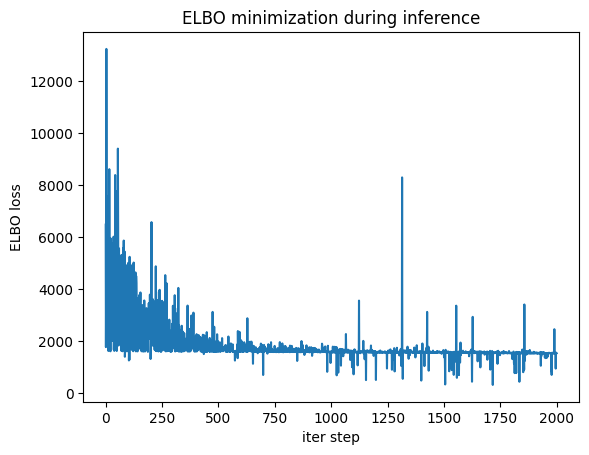

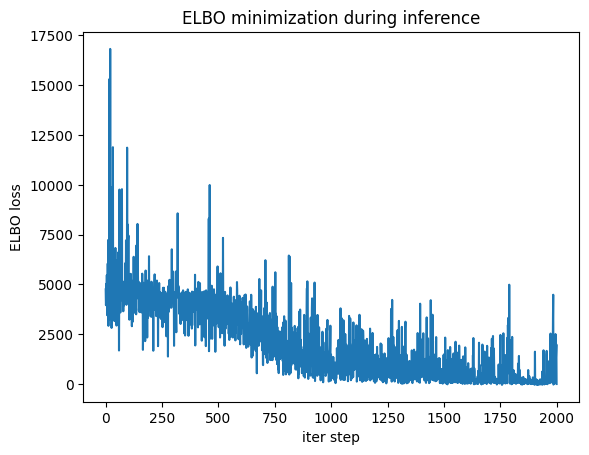

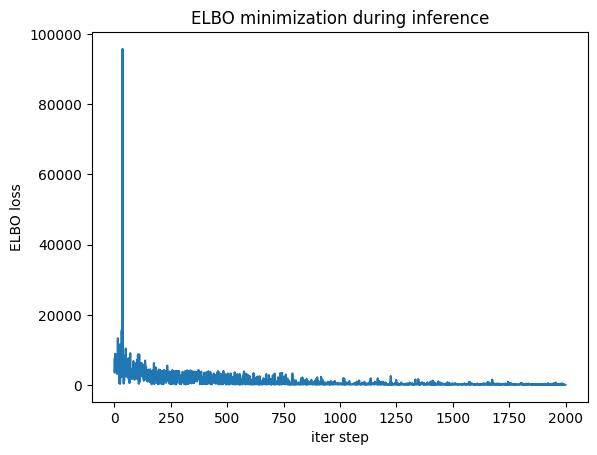

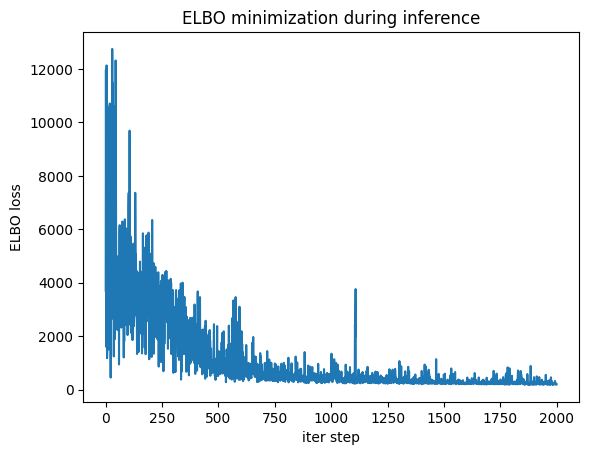

In [70]:
# inference results
pos_dict = {}

# doing inference
# data structure is (2,50,14000,5) with 50% LL choosing grouping
for i in range(test_data.shape[0]):
    for j in range(test_data[i].shape[0]):
        real_data = test_data[i][j]
        real_data = torch.tensor(real_data).to('cuda')
        # this is for running the notebook in our testing framework
        smoke_test = ('CI' in os.environ)
        # the step was 2000
        n_steps = 2 if smoke_test else 2000

        # assert pyro.__version__.startswith('1.8.6')

        # clear the param store in case we're in a REPL
        pyro.clear_param_store()# setup the optimizer
        # the learning rate was 0.0005 , "betas": (0.90, 0.999)
        # tried "n_par":15 in adam params but it does not have this argument
        adam_params = {"lr": 0.01}
        optimizer = Adam(adam_params)
        # setup the inference algorithm
        svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
        # svi = SVI(model_gamma, guide_gamma, optimizer, loss=Trace_ELBO())

        loss = []
        pbar = tqdm(range(n_steps), position = 0)
        # do gradient steps
        for step in pbar:
            loss.append(torch.tensor(svi.step(real_data)))
            pbar.set_description("Mean ELBO %6.2f" % torch.tensor(loss[-20:]).mean())
            # for name, value in pyro.get_param_store().items():
            #     print(name, pyro.param(name))
            if torch.isnan(loss[-1]):
                break

        plt.figure()
        plt.plot(loss)
        plt.xlabel("iter step")
        plt.ylabel("ELBO loss")
        plt.title("ELBO minimization during inference")

        plt.savefig(str(param_list[i][j]) +'.png')

        one_dict = {}
        for name, value in pyro.get_param_store().items():
            one_dict[name] = value
        
        pos_dict[i,j] = one_dict

In [13]:
pos_dict[0,0]['m_locs']

tensor([[ 0.2240, -0.2703,  0.2703, -0.7976, -2.0657, -1.0395,  1.0395]],
       requires_grad=True)

In [20]:
pos_dict

{(0,
  0): {'m_hyp': tensor([ 0.1179, -0.1965,  0.3395, -0.4200, -0.4832, -0.2930,  0.4203, -7.6427,
          -9.2597, -9.6751, -8.8882, -7.1180, -8.5074, -8.6144],
         requires_grad=True), 'scale_tril_hyp': tensor([[ 2.6537e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-3.9986e-02,  3.8098e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [-5.8431e-02, -1.3444e-01,  3.7703e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 2.0101e-02,  1.2934e-01, -1.1118e-01,  3.2191e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  

In [26]:
# change the dictionary to numpy instead of tensor
# because somehow the tensor cannot be save with pickle
numpy_dict = {}
for i in pos_dict.keys():
    temp_dict = {}
    temp_dict['params'] = param_list[i]
    for j in pos_dict[i].keys():
        value = pos_dict[i][j].detach().cpu().numpy()
        temp_dict[j] = value
    numpy_dict[i] = temp_dict



In [ ]:
numpy_dict

In [28]:
# save the dictionary
with open('Documents/pyro_models/files_to_run/results/test.pkl', 'wb') as f:
    pickle.dump(numpy_dict, f)